# Glacier Loss Partitioning

In [1]:
import os
from tqdm import tqdm

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Point
import xarray as xr

### Filenames

In [2]:
main_directory = os.getcwd()

basin_csv_fn = '15min_flwdir_seg_endrh_v2_Mouth_ID.csv'
basin_tif_fn = 'MERIT_plus_15min_v1_IDs_wcrs.tif'
rgiids_wbasins_fn = 'RGI60_wMERIT_IDs.csv'

wbm_fp_primary = '/Volumes/TOSHIBA-WBM/NSLCT/'

scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
gcm_names = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 
             'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

# Plotting details
ssp_name_dict = {'ssp126':'SSP1-2.6',
                 'ssp245':'SSP2-4.5',
                 'ssp370':'SSP3-7.0',
                 'ssp585':'SSP5-8.5',
                }

ssp_colordict = {'ssp126':'#DE944B', 'ssp245':'#D25B4E', 'ssp370':'#9F2C2A', 'ssp585':'#7E2825'} # Yellow-Red

### Process and export only datasets needed (netcdf files)
- yearly losses (evapotranspiration and consumption) globally aggregated
- yearly stored water

In [3]:
# ignore the divide by 0 error
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
overwrite = False

def load_variable_data(wbm_fp, vn, year):
    vn_fp = wbm_fp + vn + '/'
    vn_fn = 'wbm_' + str(year) + '.nc'
    ds_vn = xr.open_dataset(vn_fp + vn_fn)
    return ds_vn[vn].values

for gcm_name in gcm_names:
    for scenario in scenarios:

        processed_fp = 'wbm_processed/losscomponents-yearly/'
        if not os.path.exists(processed_fp):
            os.makedirs(processed_fp)
        
        processed_fn = 'wbm_' + gcm_name + '_' + scenario + '_2000_2099_v4-loss_components.nc'

        if not os.path.exists(processed_fp + processed_fn) or overwrite:
            print('processing ', gcm_name, scenario)

            wbm_fp = wbm_fp_primary + 'NSLCT_' + gcm_name + '_' + scenario + '_2000_2099_v4/yearly/'
    
            years = np.arange(2016, 2100)
            etIrrCrops_km3yr_all = np.zeros(len(years))
            IrrEvap_km3yr_all = np.zeros(len(years))
            endoEvap_km3yr_all = np.zeros(len(years))
            openWaterEvap_km3yr_all = np.zeros(len(years))
            glac_dil_km3yr_all = np.zeros(len(years))
            
            soilMoist_km3_all = np.zeros(len(years))
            grndWater_km3_all = np.zeros(len(years))
            resStorage_km3_all = np.zeros(len(years))
            runoffStrg_km3_all = np.zeros(len(years))
            endoStrg_km3_all  = np.zeros(len(years))
            
            for nyear, year in enumerate(tqdm(years)):
    
                # print(year)
    
                cell_area_fp = wbm_fp_primary + 'NSLCT_' + gcm_name + '_' + scenario + '_2000_2099_v4/cell_area/'
                cell_area_fn = 'full_cell_area.nc'
                ds_cell_area = xr.open_dataset(cell_area_fp + cell_area_fn)
                cell_area = ds_cell_area.cell_area.values
                
                wbm_fp = wbm_fp_primary + 'NSLCT_' + gcm_name + '_' + scenario + '_2000_2099_v4/yearly/'
    
                # ----- EVAPOTRANSPIRATION & CONSUMPTION COMPONENTS -----
                # GLACIER LOSSES: ET from irrigated crops
                etIrrCrops_mm_pg = load_variable_data(wbm_fp, 'etIrrCrops_mm_pg', year)
                etIrrCrops_km3yr = np.nansum(etIrrCrops_mm_pg * cell_area / 1e6 * 365)
    
                # GLACIER LOSSES: ET from irrigation water
                IrrEvap_mm_pg = load_variable_data(wbm_fp, 'IrrEvap_mm_pg', year)
                IrrEvap_km3yr = np.nansum(IrrEvap_mm_pg * cell_area / 1e6 * 365)
    
                # GLACIER LOSSES: ET from endorheic lakes
                endoEvap_mm_pg = load_variable_data(wbm_fp, 'endoEvap_mm_pg', year) # units are really mm/d (Alex confirmed 1/6/2025)
                endoEvap_km3yr = np.nansum(endoEvap_mm_pg * cell_area / 1e6 * 365)
                
                # GLACIER LOSSES: ET from open water
                openWaterEvap_mm_pg = load_variable_data(wbm_fp, 'openWaterEvap_mm_pg', year) # units are really m3/d (Alex confirmed 1/6/2025)
                if gcm_name not in ['NorESM2-MM']:
                    openWaterEvap_km3yr = np.nansum(openWaterEvap_mm_pg / 1e9 * 365)
                else:
                    openWaterEvap_km3yr = np.nansum(openWaterEvap_mm_pg * cell_area / 1e6 * 365) # NorESM2 runs were updated; hence different code here
    
                # GLACIER LOSSES: DOMESTIC, INDUSTRIAL, AND LIVESTOCK (SURFACE WATER & GROUNDWATER)
                # Surface Water
                resStorage_mm_pg = load_variable_data(wbm_fp, 'resStorage_mm_pg', year)
                resStorage = load_variable_data(wbm_fp, 'resStorage', year)
                domUseSfWt = load_variable_data(wbm_fp, 'domUseSfWt', year)
                indUseSfWt = load_variable_data(wbm_fp, 'indUseSfWt', year)
                stkUseSfWt = load_variable_data(wbm_fp, 'stkUseSfWt', year)
    
                glac_dil_from_river = np.nansum((resStorage_mm_pg/(resStorage/(cell_area*1e6)*1e3))*
                                                (domUseSfWt*0.16+indUseSfWt*0.11+stkUseSfWt*0.11)*(cell_area*1e-6)*365)
                
                # Groundwater
                grndWater_mm_pg = load_variable_data(wbm_fp, 'grndWater_mm_pg', year)
                grndWater = load_variable_data(wbm_fp, 'grdWater', year)
                domUseGrWt = load_variable_data(wbm_fp, 'domUseGrWt', year)
                indUseGrWt = load_variable_data(wbm_fp, 'indUseGrWt', year)
                stkUseGrWt = load_variable_data(wbm_fp, 'stkUseGrWt', year)
    
                glac_dil_from_groundwater = np.nansum((grndWater_mm_pg/grndWater)*(domUseGrWt*0.16+indUseGrWt*0.11+stkUseGrWt*0.11)*(cell_area*1e-6)*365)
    
                # Total
                glac_dil_km3yr = glac_dil_from_river + glac_dil_from_groundwater
    
    
                # ----- STORAGE COMPONENTS -----
                # GLACIER STORAGE: Soil water storage
                soilMoist_mm_pg = load_variable_data(wbm_fp, 'soilMoist_mm_pg', year)
                soilMoist_km3 = np.nansum(soilMoist_mm_pg * cell_area / 1e6)
                
                # GLACIER STORAGE: Groundwater storage
                grndWater_mm_pg = load_variable_data(wbm_fp, 'grndWater_mm_pg', year)
                grndWater_km3 = np.nansum(grndWater_mm_pg * cell_area / 1e6)
                
                # GLACIER STORAGE: Stream/reservoir storage
                resStorage_mm_pg = load_variable_data(wbm_fp, 'resStorage_mm_pg', year)
                resStorage_km3 = np.nansum(resStorage_mm_pg * cell_area / 1e6)
                
                # GLACIER STORAGE: Runoff storage
                runoffStrg_mm_pg = load_variable_data(wbm_fp, 'runoffStrg_mm_pg', year)
                runoffStrg_km3 = np.nansum(runoffStrg_mm_pg * cell_area / 1e6)
                
                # GLACIER STORAGE: Endorheic lake storage
                endoStrg_mm_pg = load_variable_data(wbm_fp, 'endoStrg_mm_pg', year)
                endoStrg_km3 = np.nansum(endoStrg_mm_pg * cell_area / 1e6)
    
                # STORE DATA
                etIrrCrops_km3yr_all[nyear] = etIrrCrops_km3yr
                IrrEvap_km3yr_all[nyear] = IrrEvap_km3yr
                endoEvap_km3yr_all[nyear] = endoEvap_km3yr
                openWaterEvap_km3yr_all[nyear] = openWaterEvap_km3yr
                glac_dil_km3yr_all[nyear] = glac_dil_km3yr
                
                soilMoist_km3_all[nyear] = soilMoist_km3
                grndWater_km3_all[nyear] = grndWater_km3
                resStorage_km3_all[nyear] = resStorage_km3
                runoffStrg_km3_all[nyear] = runoffStrg_km3
                endoStrg_km3_all[nyear] = endoStrg_km3

            # ----- Export as netcdf -----
            ds_processed = xr.Dataset(
                data_vars=dict(
                    etIrrCrops_km3yr = (["year"], etIrrCrops_km3yr_all, {'units': 'km3/yr'}),
                    IrrEvap_km3yr = (["year"], IrrEvap_km3yr_all, {'units': 'km3/yr'}),
                    endoEvap_km3yr = (["year"], endoEvap_km3yr_all, {'units': 'km3/yr'}),
                    openWaterEvap_km3yr = (["year"], openWaterEvap_km3yr_all, {'units': 'km3/yr'}),
                    glac_dil_km3yr = (["year"], glac_dil_km3yr_all, {'units': 'km3/yr'}),
                    
                    soilMoist_km3 = (["year"], soilMoist_km3_all, {'units': 'km3', 'description':'average stored during the year'}),
                    grndWater_km3 = (["year"], grndWater_km3_all, {'units': 'km3', 'description':'average stored during the year'}),
                    resStorage_km3 = (["year"], resStorage_km3_all, {'units': 'km3', 'description':'average stored during the year'}),
                    runoffStrg_km3 = (["year"], runoffStrg_km3_all, {'units': 'km3', 'description':'average stored during the year'}),
                    endoStrg_km3 = (["year"], endoStrg_km3_all, {'units': 'km3', 'description':'average stored during the year'}),
                ),
                coords=dict(
                    year=years,
                ),
                attrs=dict(description="Processed WBM data",
                           gcm=gcm_name,
                           scenario=scenario),
            )
            
            ds_processed.to_netcdf(processed_fp + processed_fn)
    
                # # SUMMARY
                # print('\n\nYear:', year)
                # print('ET:')
                # print('1. ET_irr_crops:', etIrrCrops_km3yr)
                # print('2. IrrEvap:', IrrEvap_km3yr)
                # print('3. Endorheic Evap:', endoEvap_km3yr)
                # print('4. OpenWater Evap:', openWaterEvap_km3yr)
                # print('5. DIL:', glac_dil_km3yr)
                
                # print('\nStorage:')
                # print('1. Soil moisture:', soilMoist_km3)
                # print('2. Groundwater:', grndWater_km3)
                # print('3. Reservoirs:', resStorage_km3)
                # print('4. Runoff:', runoffStrg_km3)
                # print('5. Endorheic:', endoStrg_km3)    
    

In [5]:
# vn = 'openWaterEvap_mm_pg'
# vn_fp = wbm_fp + vn + '/'
# vn_fn = 'wbm_' + str(year) + '.nc'
# ds_vn = xr.open_dataset(vn_fp + vn_fn)
# ds_vn[vn]

# Fraction of each component

In [6]:
losses_km3yr_all = {}
etIrrCrops_km3yr_all = {}
IrrEvap_km3yr_all = {}
endoEvap_km3yr_all = {}
openWaterEvap_km3yr_all = {}
glac_dil_km3yr_all = {}
soilMoist_km3yr_all = {}
grndWater_km3yr_all = {}
resStorage_km3yr_all = {}
runoffStrg_km3yr_all = {}
endoStrg_km3yr_all = {}
storage_km3yr_all = {}
total_km3yr_all = {}

for scenario in scenarios:

    losses_km3yr_all[scenario] = None
    etIrrCrops_km3yr_all[scenario] = None
    IrrEvap_km3yr_all[scenario] = None
    endoEvap_km3yr_all[scenario] = None
    openWaterEvap_km3yr_all[scenario] = None
    glac_dil_km3yr_all[scenario] = None
    soilMoist_km3yr_all[scenario] = None
    grndWater_km3yr_all[scenario] = None
    resStorage_km3yr_all[scenario] = None
    runoffStrg_km3yr_all[scenario] = None
    endoStrg_km3yr_all[scenario] = None
    storage_km3yr_all[scenario] = None
    total_km3yr_all[scenario] = None
    
    for ngcm, gcm_name in enumerate(gcm_names):
        
        processed_fp = 'wbm_processed/losscomponents-yearly/'
        processed_fn = 'wbm_' + gcm_name + '_' + scenario + '_2000_2099_v4-loss_components.nc'

        ds = xr.open_dataset(processed_fp + processed_fn)

        years = ds.year.values[:-1]

        # ----- LOSSES -----
        etIrrCrops_km3yr = ds.etIrrCrops_km3yr.values[:-1]
        IrrEvap_km3yr = ds.IrrEvap_km3yr.values[:-1]
        endoEvap_km3yr = ds.endoEvap_km3yr.values[:-1]
        openWaterEvap_km3yr = ds.openWaterEvap_km3yr.values[:-1]
        glac_dil_km3yr = ds.glac_dil_km3yr.values[:-1]

        losses_km3yr = etIrrCrops_km3yr + IrrEvap_km3yr + endoEvap_km3yr + openWaterEvap_km3yr + glac_dil_km3yr

        # percentages of storage
        etIrrCrops_perc = 100 * etIrrCrops_km3yr / losses_km3yr
        IrrEvap_perc = 100 * IrrEvap_km3yr / losses_km3yr
        endoEvap_perc = 100 * endoEvap_km3yr / losses_km3yr
        openWaterEvap_perc = 100 * openWaterEvap_km3yr / losses_km3yr
        glac_dil_perc = 100 * glac_dil_km3yr / losses_km3yr

        
        # ----- STORAGE -----
        soilMoist_km3 = ds.soilMoist_km3.values
        grndWater_km3 = ds.grndWater_km3.values
        resStorage_km3 = ds.resStorage_km3.values
        runoffStrg_km3 = ds.runoffStrg_km3.values
        endoStrg_km3 = ds.endoStrg_km3.values

        # Storage Change (positive is retaining more glacier runoff; negative is losing it)
        soilMoist_km3yr = soilMoist_km3[1:] - soilMoist_km3[:-1]
        grndWater_km3yr = grndWater_km3[1:] - grndWater_km3[:-1]
        resStorage_km3yr = resStorage_km3[1:] - resStorage_km3[:-1]
        runoffStrg_km3yr = runoffStrg_km3[1:] - runoffStrg_km3[:-1]
        endoStrg_km3yr = endoStrg_km3[1:] - endoStrg_km3[:-1]

        storage_km3yr = soilMoist_km3yr + grndWater_km3yr + resStorage_km3yr + runoffStrg_km3yr + endoStrg_km3yr

        soilMoist_perc = 100 * soilMoist_km3yr / storage_km3yr
        grndWater_perc = 100 * grndWater_km3yr / storage_km3yr
        resStorage_perc = 100 * resStorage_km3yr / storage_km3yr
        runoffStrg_perc = 100 * runoffStrg_km3yr / storage_km3yr
        endoStrg_perc = 100 * endoStrg_km3yr / storage_km3yr

        total_km3yr = losses_km3yr + storage_km3yr

        # Record data and percentages for averaging
        if ngcm == 0:
            losses_km3yr_all[scenario] = losses_km3yr[np.newaxis,:]
            etIrrCrops_km3yr_all[scenario] = etIrrCrops_km3yr[np.newaxis,:]
            IrrEvap_km3yr_all[scenario] = IrrEvap_km3yr[np.newaxis,:]
            endoEvap_km3yr_all[scenario] = endoEvap_km3yr[np.newaxis,:]
            openWaterEvap_km3yr_all[scenario] = openWaterEvap_km3yr[np.newaxis,:]
            glac_dil_km3yr_all[scenario] = glac_dil_km3yr[np.newaxis,:]
            soilMoist_km3yr_all[scenario] = soilMoist_km3yr[np.newaxis,:]
            grndWater_km3yr_all[scenario] = grndWater_km3yr[np.newaxis,:]
            resStorage_km3yr_all[scenario] = resStorage_km3yr[np.newaxis,:]
            runoffStrg_km3yr_all[scenario] = runoffStrg_km3yr[np.newaxis,:]
            endoStrg_km3yr_all[scenario] = endoStrg_km3yr[np.newaxis,:]
            storage_km3yr_all[scenario] = storage_km3yr[np.newaxis,:]
            total_km3yr_all[scenario] = total_km3yr[np.newaxis,:]
        else:
            losses_km3yr_all[scenario] = np.concatenate((losses_km3yr_all[scenario], losses_km3yr[np.newaxis,:]), axis=0)
            etIrrCrops_km3yr_all[scenario] = np.concatenate((etIrrCrops_km3yr_all[scenario], etIrrCrops_km3yr[np.newaxis,:]), axis=0)
            IrrEvap_km3yr_all[scenario] = np.concatenate((IrrEvap_km3yr_all[scenario], IrrEvap_km3yr[np.newaxis,:]), axis=0)
            endoEvap_km3yr_all[scenario] = np.concatenate((endoEvap_km3yr_all[scenario], endoEvap_km3yr[np.newaxis,:]), axis=0)
            openWaterEvap_km3yr_all[scenario] = np.concatenate((openWaterEvap_km3yr_all[scenario], openWaterEvap_km3yr[np.newaxis,:]), axis=0)
            glac_dil_km3yr_all[scenario] = np.concatenate((glac_dil_km3yr_all[scenario], glac_dil_km3yr[np.newaxis,:]), axis=0)
            soilMoist_km3yr_all[scenario] = np.concatenate((soilMoist_km3yr_all[scenario], soilMoist_km3yr[np.newaxis,:]), axis=0)
            grndWater_km3yr_all[scenario] = np.concatenate((grndWater_km3yr_all[scenario], grndWater_km3yr[np.newaxis,:]), axis=0)
            resStorage_km3yr_all[scenario] = np.concatenate((resStorage_km3yr_all[scenario], resStorage_km3yr[np.newaxis,:]), axis=0)
            runoffStrg_km3yr_all[scenario] = np.concatenate((runoffStrg_km3yr_all[scenario], runoffStrg_km3yr[np.newaxis,:]), axis=0)
            endoStrg_km3yr_all[scenario] = np.concatenate((endoStrg_km3yr_all[scenario], endoStrg_km3yr[np.newaxis,:]), axis=0)
            storage_km3yr_all[scenario] = np.concatenate((storage_km3yr_all[scenario], storage_km3yr[np.newaxis,:]), axis=0)
            total_km3yr_all[scenario] = np.concatenate((total_km3yr_all[scenario], total_km3yr[np.newaxis,:]), axis=0)

        

## Plot ET/Consumption vs. Storage for SSPs

In [7]:
results_fp = 'wbm_results/'
fig_fp = results_fp + '_figures/'

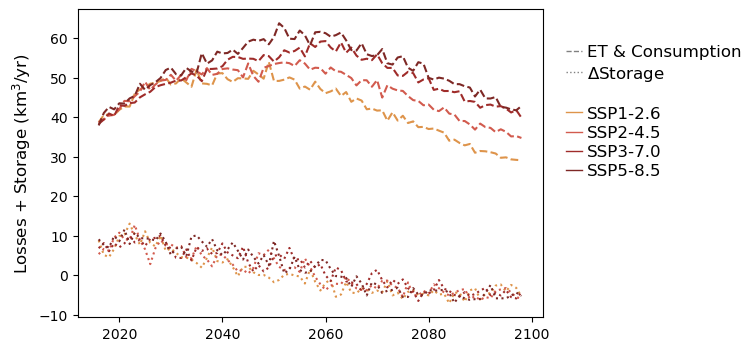

In [8]:
plot_total = False
fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                      gridspec_kw={'wspace':0.5, 'hspace':0.1})

for scenario in scenarios:

    losses_km3yr_med = np.median(losses_km3yr_all[scenario], axis=0)
    storage_km3yr_med = np.median(storage_km3yr_all[scenario], axis=0)
    total_km3yr_med = np.median(total_km3yr_all[scenario], axis=0)
    
    ax[0,0].plot(years, losses_km3yr_med, linestyle='--', color=ssp_colordict[scenario])
    ax[0,0].plot(years, storage_km3yr_med, linestyle=':', color=ssp_colordict[scenario],)
    if plot_total:
        ax[0,0].plot(years, total_km3yr_med, color=ssp_colordict[scenario])

ax[0,0].set_ylabel('Losses + Storage (km$^{3}$/yr)', size=12)

# Legend
leg_lines = []
leg_labels = []

if plot_total:
    line = Line2D([0],[0], color='grey', linestyle='-', linewidth=1)
    leg_lines.append(line)
    leg_labels.append('Total')

line = Line2D([0],[0], color='grey', linestyle='--', linewidth=1)
leg_lines.append(line)
leg_labels.append('ET & Consumption')
line = Line2D([0],[0], color='grey', linestyle=':', linewidth=1)
leg_lines.append(line)
leg_labels.append(r'$\Delta$Storage')
# dummy
line = Line2D([0],[0], color='grey', linestyle='-', linewidth=0)
leg_lines.append(line)
leg_labels.append(' ')

for scenario in scenarios:
    line = Line2D([0],[0], color=ssp_colordict[scenario], linestyle='-', linewidth=1)
    leg_lines.append(line)
    leg_labels.append(ssp_name_dict[scenario])    



ax[0,0].legend(leg_lines, leg_labels, loc=(1.05,0.45), fontsize=12, labelspacing=0.25, handlelength=1, 
               handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)

fig.set_size_inches(6,4)
fig.savefig(fig_fp + 'losses_vs_storage_km3yr_ssps.png', dpi=300, bbox_inches='tight')

## Plot ET/Consumption vs. Storage for SSPs (Percentages)

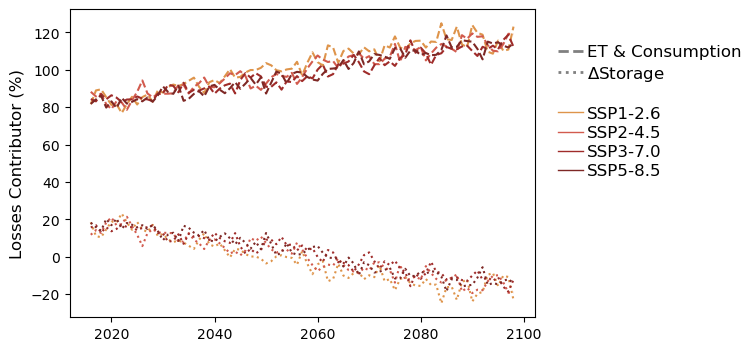

In [9]:
fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                      gridspec_kw={'wspace':0.5, 'hspace':0.1})

for scenario in scenarios:

    losses_perc_med = np.median(100 * losses_km3yr_all[scenario] / total_km3yr_all[scenario], axis=0)
    storage_perc_med = np.median(100 * storage_km3yr_all[scenario] / total_km3yr_all[scenario], axis=0)
    
    ax[0,0].plot(years, losses_perc_med, linestyle='--', color=ssp_colordict[scenario])
    ax[0,0].plot(years, storage_perc_med, linestyle=':', color=ssp_colordict[scenario],)

ax[0,0].set_ylabel('Losses Contributor (%)', size=12)

# Legend
leg_lines = []
leg_labels = []

line = Line2D([0],[0], color='grey', linestyle='--', linewidth=2)
leg_lines.append(line)
leg_labels.append('ET & Consumption')
line = Line2D([0],[0], color='grey', linestyle=':', linewidth=2)
leg_lines.append(line)
leg_labels.append(r'$\Delta$Storage')
# dummy
line = Line2D([0],[0], color='grey', linestyle='-', linewidth=0)
leg_lines.append(line)
leg_labels.append(' ')

for scenario in scenarios:
    line = Line2D([0],[0], color=ssp_colordict[scenario], linestyle='-', linewidth=1)
    leg_lines.append(line)
    leg_labels.append(ssp_name_dict[scenario])    

ax[0,0].legend(leg_lines, leg_labels, loc=(1.05,0.45), fontsize=12, labelspacing=0.25, handlelength=1.5, 
               handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)

fig.set_size_inches(6,4)
fig.savefig(fig_fp + 'losses_vs_storage_perc_ssps.png', dpi=300, bbox_inches='tight')

## Plot ET/Consumption Components

Mean of multi-GCM median (km3/yr):
  Total losses: 46.68
  Endorheic Evap: 29.65
  Open Water Evap: 9.96
  Irrigation ET: 6.74
  DIL: 0.3


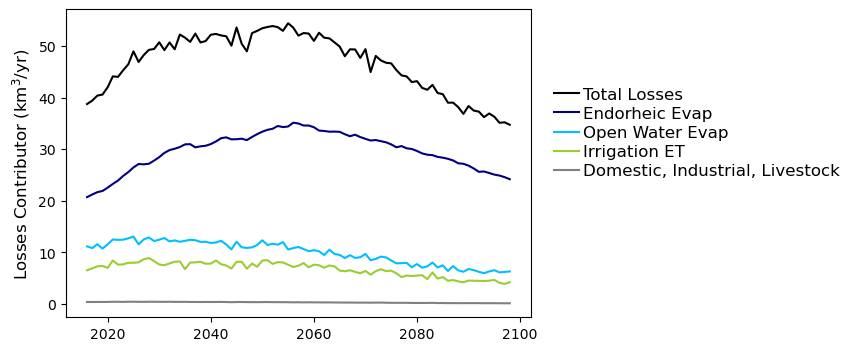

In [10]:
fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                      gridspec_kw={'wspace':0.5, 'hspace':0.1})

for scenario in ['ssp245']:

    losses_med = np.median(losses_km3yr_all[scenario], axis=0)
    ET_irr_med = np.median(etIrrCrops_km3yr_all[scenario] + IrrEvap_km3yr_all[scenario], axis=0)
    endoEvap_med = np.median(endoEvap_km3yr_all[scenario], axis=0)
    openWaterEvap_med = np.median(openWaterEvap_km3yr_all[scenario], axis=0)
    DIL_med = np.median(glac_dil_km3yr_all[scenario], axis=0)

    ax[0,0].plot(years, losses_med, linestyle='-', color='k', label='Total Losses')
    ax[0,0].plot(years, endoEvap_med, linestyle='-', color='navy', label='Endorheic Evap')
    ax[0,0].plot(years, openWaterEvap_med, linestyle='-', color='deepskyblue', label='Open Water Evap')
    ax[0,0].plot(years, ET_irr_med, linestyle='-', color='yellowgreen', label='Irrigation ET')
    ax[0,0].plot(years, DIL_med, linestyle='-', color='grey', label='Domestic, Industrial, Livestock')

ax[0,0].set_ylabel('Losses Contributor (km$^{3}$/yr)', size=12)

# Legend
ax[0,0].legend(loc=(1.05,0.45), fontsize=12, labelspacing=0.25, handlelength=1.5, 
               handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)

# Print averages:
print('Mean of multi-GCM median (km3/yr):')
print('  Total losses:', np.round(losses_med.mean(),2))
print('  Endorheic Evap:', np.round(endoEvap_med.mean(),2))
print('  Open Water Evap:', np.round(openWaterEvap_med.mean(),2))
print('  Irrigation ET:', np.round(ET_irr_med.mean(),2))
print('  DIL:', np.round(DIL_med.mean(),2))

fig.set_size_inches(6,4)
fig.savefig(fig_fp + 'losses_by_component_km3yr_ssps.png', dpi=300, bbox_inches='tight')


### Percentages

Mean of multi-GCM median (%):
  Endorheic Evap: 63.8
  Open Water Evap: 21.14
  Irrigation ET: 14.44
  DIL: 0.64


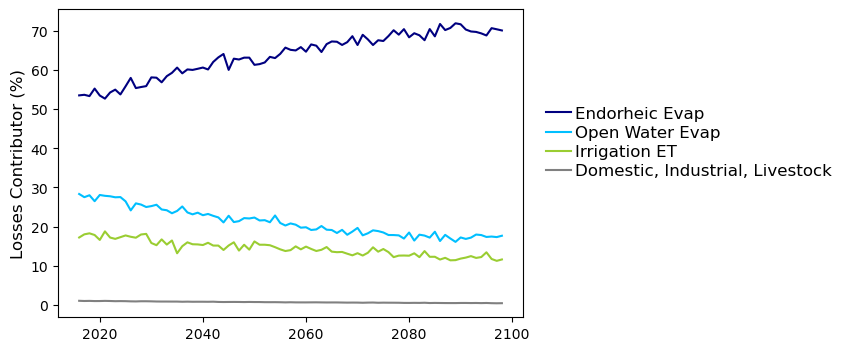

In [11]:
fig, ax = plt.subplots(1,1, squeeze=False, sharex=False, sharey=False,
                      gridspec_kw={'wspace':0.5, 'hspace':0.1})

for scenario in ['ssp245']:

    # losses_med = np.median(losses_km3yr_all[scenario], axis=0)
    ET_irr_med = np.median(100*(etIrrCrops_km3yr_all[scenario] + IrrEvap_km3yr_all[scenario])/losses_km3yr_all[scenario], axis=0)
    endoEvap_med = np.median(100*endoEvap_km3yr_all[scenario] / losses_km3yr_all[scenario], axis=0)
    openWaterEvap_med = np.median(100 * openWaterEvap_km3yr_all[scenario] / losses_km3yr_all[scenario], axis=0)
    DIL_med = np.median(100 * glac_dil_km3yr_all[scenario] / losses_km3yr_all[scenario], axis=0)

    # ax[0,0].plot(years, losses_med, linestyle='-', color='k', label='Total Losses')
    ax[0,0].plot(years, endoEvap_med, linestyle='-', color='navy', label='Endorheic Evap')
    ax[0,0].plot(years, openWaterEvap_med, linestyle='-', color='deepskyblue', label='Open Water Evap')
    ax[0,0].plot(years, ET_irr_med, linestyle='-', color='yellowgreen', label='Irrigation ET')
    ax[0,0].plot(years, DIL_med, linestyle='-', color='grey', label='Domestic, Industrial, Livestock')

ax[0,0].set_ylabel('Losses Contributor (%)', size=12)

# Legend
ax[0,0].legend(loc=(1.05,0.45), fontsize=12, labelspacing=0.25, handlelength=1.5, 
               handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)

# Print averages:
print('Mean of multi-GCM median (%):')
print('  Endorheic Evap:', np.round(endoEvap_med.mean(),2))
print('  Open Water Evap:', np.round(openWaterEvap_med.mean(),2))
print('  Irrigation ET:', np.round(ET_irr_med.mean(),2))
print('  DIL:', np.round(DIL_med.mean(),2))

fig.set_size_inches(6,4)
fig.savefig(fig_fp + 'losses_by_component_perc_ssps.png', dpi=300, bbox_inches='tight')

# Values for paper

In [12]:
for scenario in scenarios:
    print('\n', scenario)

    losses_perc = 100 * losses_km3yr_all[scenario]/total_km3yr_all[scenario]
    ET_irr_perc = 100*(etIrrCrops_km3yr_all[scenario] + IrrEvap_km3yr_all[scenario])/total_km3yr_all[scenario]
    endoEvap_perc = 100*endoEvap_km3yr_all[scenario] / total_km3yr_all[scenario]
    openWaterEvap_perc = 100 * openWaterEvap_km3yr_all[scenario] / total_km3yr_all[scenario]
    DIL_perc = 100 * glac_dil_km3yr_all[scenario] / total_km3yr_all[scenario]
    storage_perc = 100 * storage_km3yr_all[scenario] / total_km3yr_all[scenario]

    print('Median, Min, Max of Average from 2015-2098 (%):')
    def print_stats(name, data, ndigits=0):
        print(' ', name + ':', 
              np.round(np.median(data.mean(1)),ndigits), 
              np.round(np.min(data.mean(1)),ndigits), 
              np.round(np.max(data.mean(1)),ndigits))

    print_stats('losses', losses_perc)
    print_stats('Endorheic Evap', endoEvap_perc)
    print_stats('Open Water Evap', openWaterEvap_perc)
    print_stats('Irrigation ET', ET_irr_perc)
    print_stats('DIL', DIL_perc, ndigits=1)
    print_stats('Storage', storage_perc)


 ssp126
Median, Min, Max of Average from 2015-2098 (%):
  losses: 103.0 99.0 106.0
  Endorheic Evap: 66.0 61.0 71.0
  Open Water Evap: 22.0 21.0 23.0
  Irrigation ET: 15.0 13.0 16.0
  DIL: 0.6 0.5 0.7
  Storage: -3.0 -6.0 1.0

 ssp245
Median, Min, Max of Average from 2015-2098 (%):
  losses: 101.0 98.0 102.0
  Endorheic Evap: 65.0 62.0 66.0
  Open Water Evap: 21.0 20.0 22.0
  Irrigation ET: 14.0 13.0 16.0
  DIL: 0.6 0.6 0.7
  Storage: -1.0 -2.0 2.0

 ssp370
Median, Min, Max of Average from 2015-2098 (%):
  losses: 99.0 95.0 100.0
  Endorheic Evap: 63.0 58.0 65.0
  Open Water Evap: 20.0 19.0 22.0
  Irrigation ET: 15.0 13.0 17.0
  DIL: 0.7 0.6 0.7
  Storage: 1.0 0.0 5.0

 ssp585
Median, Min, Max of Average from 2015-2098 (%):
  losses: 99.0 97.0 100.0
  Endorheic Evap: 64.0 61.0 66.0
  Open Water Evap: 20.0 19.0 21.0
  Irrigation ET: 14.0 13.0 16.0
  DIL: 0.5 0.5 0.6
  Storage: 1.0 0.0 3.0


In [18]:
# Combine all the scenarios
print('All Scenarios together')
for nscenario, scenario in enumerate(scenarios):

    if nscenario == 0:
        losses_combined = losses_km3yr_all[scenario]
    else:
        losses_combined = np.concatenate((losses_combined, losses_km3yr_all[scenario]), axis=0)
        
#     =  = 100 * losses_km3yr_all[scenario]/total_km3yr_all[scenario]
#     ET_irr_perc = 100*(etIrrCrops_km3yr_all[scenario] + IrrEvap_km3yr_all[scenario])/total_km3yr_all[scenario]
#     endoEvap_perc = 100*endoEvap_km3yr_all[scenario] / total_km3yr_all[scenario]
#     openWaterEvap_perc = 100 * openWaterEvap_km3yr_all[scenario] / total_km3yr_all[scenario]
#     DIL_perc = 100 * glac_dil_km3yr_all[scenario] / total_km3yr_all[scenario]
#     storage_perc = 100 * storage_km3yr_all[scenario] / total_km3yr_all[scenario]

#     if nscenario == 0:
#         losses_perc_all = losses_perc
#         ET_irr_perc_all = ET_irr_perc
#         endoEvap_perc_all = endoEvap_perc
#         openWaterEvap_perc_all = openWaterEvap_perc
#         DIL_perc_all = DIL_perc
#         storage_perc_all = storage_perc
#     else:
#         losses_perc_all = np.concatenate((losses_perc_all, losses_perc), axis=0)
#         ET_irr_perc_all = np.concatenate((ET_irr_perc_all, ET_irr_perc), axis=0)
#         endoEvap_perc_all = np.concatenate((endoEvap_perc_all, endoEvap_perc), axis=0)
#         openWaterEvap_perc_all = np.concatenate((openWaterEvap_perc_all, openWaterEvap_perc), axis=0)
#         DIL_perc_all = np.concatenate((DIL_perc_all, DIL_perc), axis=0)
#         storage_perc_all = np.concatenate((storage_perc_all, storage_perc), axis=0)
        

# print('Median, Min, Max of Average from 2015-2098 (%):')
# def print_stats(name, data, ndigits=0):
#     print(' ', name + ':', 
#           np.round(np.median(data.mean(1)),ndigits), 
#           np.round(np.mean(data.mean(1)) - 1.96*np.std(data.mean(1)),ndigits),
#           np.round(np.mean(data.mean(1)) + 1.96*np.std(data.mean(1)),ndigits),
#           # np.round(np.min(data.mean(1)),ndigits), 
#           # np.round(np.max(data.mean(1)),ndigits)
#          )

# print_stats('losses', losses_perc_all)
# print_stats('Endorheic Evap', endoEvap_perc_all)
# print_stats('Open Water Evap', openWaterEvap_perc_all)
# print_stats('Irrigation ET', ET_irr_perc_all)
# print_stats('DIL', DIL_perc_all, ndigits=1)
# print_stats('Storage', storage_perc_all, ndigits=1)

All Scenarios together


(48, 83)

In [16]:
losses_km3yr_all[scenario].shape

(12, 83)

In [13]:
# Combine all the scenarios
print('All Scenarios together')
for nscenario, scenario in enumerate(scenarios):

    losses_perc = 100 * losses_km3yr_all[scenario]/total_km3yr_all[scenario]
    ET_irr_perc = 100*(etIrrCrops_km3yr_all[scenario] + IrrEvap_km3yr_all[scenario])/total_km3yr_all[scenario]
    endoEvap_perc = 100*endoEvap_km3yr_all[scenario] / total_km3yr_all[scenario]
    openWaterEvap_perc = 100 * openWaterEvap_km3yr_all[scenario] / total_km3yr_all[scenario]
    DIL_perc = 100 * glac_dil_km3yr_all[scenario] / total_km3yr_all[scenario]
    storage_perc = 100 * storage_km3yr_all[scenario] / total_km3yr_all[scenario]

    if nscenario == 0:
        losses_perc_all = losses_perc
        ET_irr_perc_all = ET_irr_perc
        endoEvap_perc_all = endoEvap_perc
        openWaterEvap_perc_all = openWaterEvap_perc
        DIL_perc_all = DIL_perc
        storage_perc_all = storage_perc
    else:
        losses_perc_all = np.concatenate((losses_perc_all, losses_perc), axis=0)
        ET_irr_perc_all = np.concatenate((ET_irr_perc_all, ET_irr_perc), axis=0)
        endoEvap_perc_all = np.concatenate((endoEvap_perc_all, endoEvap_perc), axis=0)
        openWaterEvap_perc_all = np.concatenate((openWaterEvap_perc_all, openWaterEvap_perc), axis=0)
        DIL_perc_all = np.concatenate((DIL_perc_all, DIL_perc), axis=0)
        storage_perc_all = np.concatenate((storage_perc_all, storage_perc), axis=0)
        

print('Median, Min, Max of Average from 2015-2098 (%):')
def print_stats(name, data, ndigits=0):
    print(' ', name + ':', 
          np.round(np.median(data.mean(1)),ndigits), 
          np.round(np.mean(data.mean(1)) - 1.96*np.std(data.mean(1)),ndigits),
          np.round(np.mean(data.mean(1)) + 1.96*np.std(data.mean(1)),ndigits),
          # np.round(np.min(data.mean(1)),ndigits), 
          # np.round(np.max(data.mean(1)),ndigits)
         )

print_stats('losses', losses_perc_all)
print_stats('Endorheic Evap', endoEvap_perc_all)
print_stats('Open Water Evap', openWaterEvap_perc_all)
print_stats('Irrigation ET', ET_irr_perc_all)
print_stats('DIL', DIL_perc_all, ndigits=1)
print_stats('Storage', storage_perc_all, ndigits=1)

All Scenarios together
Median, Min, Max of Average from 2015-2098 (%):
  losses: 99.0 96.0 104.0
  Endorheic Evap: 64.0 60.0 68.0
  Open Water Evap: 21.0 19.0 23.0
  Irrigation ET: 15.0 12.0 17.0
  DIL: 0.6 0.5 0.7
  Storage: 0.5 -4.4 4.4


# Figure for Paper

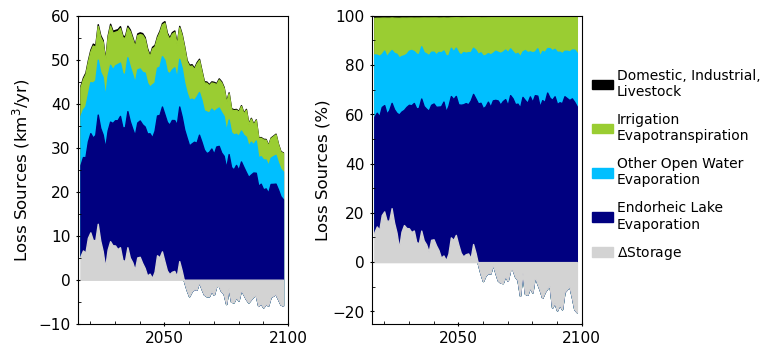

In [28]:
for scenario in ['ssp245']:

    fig, ax = plt.subplots(1,2, squeeze=False, sharex=False, sharey=False,
                      gridspec_kw={'wspace':0.4, 'hspace':0.1})

    # losses_km3yr_med = np.median(losses_km3yr_all[scenario], axis=0)
    storage_med = np.median(storage_km3yr_all[scenario], axis=0)
    losses_med = np.median(losses_km3yr_all[scenario], axis=0)

    
    ET_irr_med = np.median(etIrrCrops_km3yr_all[scenario] + IrrEvap_km3yr_all[scenario], axis=0)
    endoEvap_med = np.median(endoEvap_km3yr_all[scenario], axis=0)
    openWaterEvap_med = np.median(openWaterEvap_km3yr_all[scenario], axis=0)
    DIL_med = np.median(glac_dil_km3yr_all[scenario], axis=0)

    total_med = storage_med + ET_irr_med + endoEvap_med + openWaterEvap_med + DIL_med

    # ----- VALUES (km3/yr) -----
    ax[0,0].fill_between(years, storage_med, storage_med + endoEvap_med + openWaterEvap_med + ET_irr_med + DIL_med, 
                         color='k', label='Domestic, Industrial, Livestock')
    ax[0,0].fill_between(years, storage_med, storage_med + endoEvap_med + openWaterEvap_med + ET_irr_med, 
                         color='yellowgreen', label='Irrigation ET')
    ax[0,0].fill_between(years, storage_med, storage_med + endoEvap_med + openWaterEvap_med, 
                         color='deepskyblue', label='Open Water Evap')
    ax[0,0].fill_between(years, storage_med, storage_med + endoEvap_med, 
                         color='navy', label='Endorheic Evap')
    # ax[0,0].fill_between(years, storage_med, storage_med + losses_med, 
    #                      color='green')
    ax[0,0].fill_between(years, 0, storage_med,
                         color='lightgray', label=r'$\Delta$Storage')
    
    ax[0,0].set_ylabel('Loss Sources (km$^{3}$/yr)', size=12)
    ax[0,0].set_xlim(2015,2100)
    ax[0,0].xaxis.set_major_locator(MultipleLocator(50))
    ax[0,0].xaxis.set_minor_locator(MultipleLocator(10))
    
    ax[0,0].set_ylim(-10, 60)
    ax[0,0].yaxis.set_major_locator(MultipleLocator(10))
    ax[0,0].yaxis.set_minor_locator(MultipleLocator(5))

    ax[0,0].tick_params(axis='both', which='major', direction='inout', right=False)
    ax[0,0].tick_params(axis='both', which='minor', direction='in', right=False)
    ax[0,0].tick_params(axis='x', labelsize=11)
    ax[0,0].tick_params(axis='y', labelsize=11)

    # ----- PERCENTAGES -----
    ax[0,1].fill_between(years, 
                         100 * storage_med / total_med, 
                         100 * (storage_med + endoEvap_med + openWaterEvap_med + ET_irr_med + DIL_med) / total_med, 
                         color='k', label='Domestic, Industrial,\nLivestock')
    ax[0,1].fill_between(years, 
                         100 * storage_med / total_med, 
                         100 * (storage_med + endoEvap_med + openWaterEvap_med + ET_irr_med) / total_med, 
                         color='yellowgreen', label='Irrigation\nEvapotranspiration')
    ax[0,1].fill_between(years, 
                         100 * storage_med / total_med, 
                         100 * (storage_med + endoEvap_med + openWaterEvap_med) / total_med, 
                         color='deepskyblue', label='Other Open Water\nEvaporation')
    ax[0,1].fill_between(years, 
                         100 * storage_med / total_med, 
                         100 * (storage_med + endoEvap_med) / total_med, 
                         color='navy', label='Endorheic Lake\nEvaporation')
    ax[0,1].fill_between(years, 0, 
                         100 * storage_med / total_med,
                         color='lightgray', label=r'$\Delta$Storage')

    ax[0,1].set_ylabel('Loss Sources (%)', size=12, labelpad=1)
    
    ax[0,1].set_xlim(2015,2100)
    ax[0,1].xaxis.set_major_locator(MultipleLocator(50))
    ax[0,1].xaxis.set_minor_locator(MultipleLocator(10))
    
    ax[0,1].set_ylim(-25, 100)
    ax[0,1].yaxis.set_major_locator(MultipleLocator(20))
    ax[0,1].yaxis.set_minor_locator(MultipleLocator(10))

    ax[0,1].tick_params(axis='both', which='major', direction='inout', right=False)
    ax[0,1].tick_params(axis='both', which='minor', direction='in', right=False)
    ax[0,1].tick_params(axis='x', labelsize=11)
    ax[0,1].tick_params(axis='y', labelsize=11)
    
    # Legend
    ax[0,1].legend(loc=(1.05,0.2), fontsize=10, labelspacing=1, handlelength=1.5, 
                   handletextpad=0.25, borderpad=0, ncol=1, columnspacing=0.5, frameon=False)
    
    fig.set_size_inches(6.5,4)
    fig.savefig(fig_fp + 'FigS1_losses_by_component_' + scenario + '.png', dpi=300, bbox_inches='tight')

In [20]:
total_med

array([44.1248268 , 45.97461697, 47.09781127, 49.91481208, 52.28183007,
       53.6535382 , 53.35993169, 58.07068081, 55.64290782, 54.48894803,
       49.96415095, 55.50789537, 58.17071404, 56.55237272, 56.77329828,
       56.94086772, 57.63220284, 55.51778503, 55.3423345 , 57.72395797,
       56.85155317, 55.13852645, 53.38512985, 55.9766546 , 56.22225326,
       56.05342999, 55.16761628, 52.58877081, 51.08812521, 52.93310295,
       53.38422158, 55.37787565, 56.61305647, 58.35583138, 58.76223432,
       56.16386157, 55.02208927, 56.25716773, 56.64937109, 53.73905378,
       57.68313286, 55.87380998, 53.05876898, 49.96078575, 48.86349562,
       48.9705546 , 48.16403337, 49.42018983, 50.21496426, 47.6367921 ,
       45.09456086, 45.04550946, 44.44017252, 45.07821887, 44.96163396,
       44.68428025, 45.76323773, 45.09374203, 43.78391364, 40.51870406,
       42.59000728, 38.95854237, 38.74680509, 38.80691681, 38.37768956,
       39.66523103, 37.95459188, 38.81935156, 35.5265226 , 36.78